## This is NLP based classification problem is solved using a simple Bidirectional LSTM based RNN. 
## If you like my work then do consider upvoting this notebook.

In [1]:
import numpy as np
import pandas as pd
import os, re, unidecode, random, math
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2

In [2]:
def data_cleaner(data):
    data = data.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    
    soup = BeautifulSoup(data, 'html.parser')
    data = soup.get_text(separator=' ')
    
    remove_http = re.sub(r'http\S+', '', data)
    data = re.sub(r"\ [A-Za-z]*\.com", " ", remove_http)
    
    data = unidecode.unidecode(data)
    data = data.lower()
    data = re.sub(r"[^a-zA-Z0-9:$-,()%.?!]+", ' ', data) 
    data = re.sub(r"[:$-,()%.?!]+", ' ',data)
    
    stoplist = stopwords.words("english")
    data = [word for word in word_tokenize(data) if word not in stoplist]
    data = " ".join(data)
    
    return data

def seed_everything(SEED = 13):
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
seed_everything()
print('seeded everything to get same output')

seeded everything to get same output


In [3]:
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
del train_df['id']
del train_df['keyword']
del train_df['location']
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(train_df.shape)
print(train_df.target.value_counts())

(7613, 2)
0    4342
1    3271
Name: target, dtype: int64


In [6]:
train_df['text'] = [data_cleaner(train_df['text'][i]) for i in tqdm(range(train_df.shape[0]))]
train_df.head()

100%|██████████| 7613/7613 [00:03<00:00, 1914.04it/s]


,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13 000 people receive wildfires evacuation ord...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [7]:
def myModel():    
    model = Sequential(name='Bidirectional_RNN')
    model.add(Embedding(1000, 256, input_length = 256))
    #model.add(Bidirectional((LSTM(512, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01)))))
    #model.add(Dropout(0.5))
    #model.add(Bidirectional((LSTM(512, return_sequences = True, recurrent_dropout=0.0))))
    #model.add(Dropout(0.5))
    
    #model.add(Bidirectional(LSTM(256, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    #model.add(Dropout(0.5))
    
    #model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    #model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    model.add(Dropout(0.4))
    #model.add(Bidirectional(LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
    #model.add(Dropout(0.4))
    
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1, activation = 'sigmoid'))
    print(model.summary())
    return model

model = myModel()    
model.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

Model: "Bidirectional_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 256)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 256, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256, 128)          164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)          

In [8]:
text = train_df['text']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text.values)
x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=256)
print('generated pad sequences')

generated pad sequences


In [9]:
y_train = train_df['target']
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

chk_point = ModelCheckpoint(
    '/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

es = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    #restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 100,
    callbacks=[es,lr,chk_point],
    shuffle=True,
    verbose=1
)

Epoch 1/100
96/96 [==============================] - 19s 109ms/step - loss: 13.3608 - Accuracy: 0.5749 - val_loss: 11.6226 - val_Accuracy: 0.5345
Epoch 2/100
96/96 [==============================] - 9s 91ms/step - loss: 10.2082 - Accuracy: 0.5793 - val_loss: 8.8917 - val_Accuracy: 0.5345
Epoch 3/100
96/96 [==============================] - 9s 92ms/step - loss: 7.8124 - Accuracy: 0.5793 - val_loss: 6.8168 - val_Accuracy: 0.5345
Epoch 4/100
96/96 [==============================] - 9s 94ms/step - loss: 5.9407 - Accuracy: 0.6658 - val_loss: 5.1167 - val_Accuracy: 0.7708
Epoch 5/100
96/96 [==============================] - 9s 94ms/step - loss: 4.4565 - Accuracy: 0.8049 - val_loss: 3.9356 - val_Accuracy: 0.7689
Epoch 6/100
96/96 [==============================] - 9s 93ms/step - loss: 3.4160 - Accuracy: 0.8171 - val_loss: 3.0295 - val_Accuracy: 0.7833
Epoch 7/100
96/96 [==============================] - 9s 94ms/step - loss: 2.6280 - Accuracy: 0.8322 - val_loss: 2.3850 - val_Accuracy: 0.7617
E

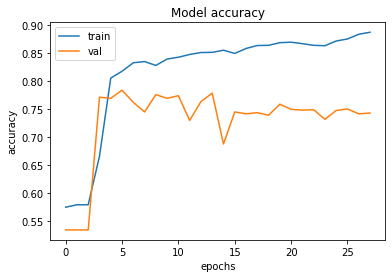

In [10]:
# Reference: https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

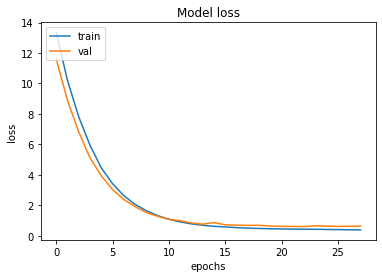

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
test_df['text'] = [data_cleaner(test_df['text'][i]) for i in tqdm(range(test_df.shape[0]))]
test_df.head()

100%|██████████| 3263/3263 [00:01<00:00, 1687.08it/s]


,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan


In [13]:
text = test_df['text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=256)
print('generated pad sequences')

generated pad sequences


In [14]:
model = load_model('./best_model.h5')
preds = model.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

In [15]:
submission=pd.DataFrame()
submission['id']=test_df['id'].to_list()
submission['target']=pred

In [16]:
submission.to_csv('submission.csv',index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
